In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
players_df = pd.read_csv('Player_URL_Stats_Real.csv')
#players_df = pd.read_csv('Player_URL_Stats.csv')
odds_df = pd.read_csv('NBA_Odds.csv')

local_teams = pd.read_csv('local_teams.csv')
visit_teams = pd.read_csv('visit_teams.csv')

In [3]:
joint = odds_df.set_index('Name').join(players_df.set_index('Name'))
joint[joint['href'].isnull()]

,Bet,O,U,href
Name,,,,
Dennis Schroder,20.5,−110,−120,NaN
Nikola Jokic,47.5,−120,−110,NaN


In [4]:
joint = joint[~joint['href'].isnull()]
print(f'# Rows: {joint.shape[0]}')

# Rows: 30


In [5]:
def get_game_stats(game: dict) -> dict:
    local_team = local_teams[local_teams['local_team'] == game['team']].to_dict('records')[0]
    visit_team = visit_teams[visit_teams['visit_team'] == game['team_opp']].to_dict('records')[0]

    # player = game | local_team | visit_team
    player = {**game, **local_team, **visit_team}
    
    return player

In [6]:
def get_player_stats(idx, url):
    df = []
    
    time.sleep(1)
    
    req = requests.get(url)
    soup = bs(req.content, 'lxml')
    
    rows = soup.find('table', {'id': 'pgl_basic'}) \
                .find('tbody').find_all('tr')
    
    for row in rows:
        cond = row.find('td', {'data-stat': 'reason'})
        cond2 = row.find('td')
        
        if (not cond) and (cond2):
            game = {}
            
            game['date'] = row.find('td', {'data-stat': 'date_game'}) \
                              .find('a').text
            
            game['team'] = row.find('td', {'data-stat': 'team_id'}) \
                              .find('a').text
            game['team_href'] = row.find('td', {'data-stat': 'team_id'}) \
                              .find('a').get('href')
            
            game['team_opp'] = row.find('td', {'data-stat': 'opp_id'}) \
                                  .find('a').text
            game['team_opp_href'] = row.find('td', {'data-stat': 'opp_id'}) \
                                  .find('a').get('href')
            
            mp = row.find('td', {'data-stat': 'mp'}).text
            i = mp.index(':')
            game['mp'] = float(mp[:i])
            
            game['fg'] = int(row.find('td', {'data-stat': 'fg'}).text)
            
            try:
                game['fg_pct'] = float(row.find('td', {'data-stat': 'fg_pct'}).text)
            except ValueError:
                game['fg_pct'] = None
                
            game['fg3'] = int(row.find('td', {'data-stat': 'fg3'}).text)
            
            try:
                game['fg3_pct'] = float(row.find('td', {'data-stat': 'fg3_pct'}).text)
            except ValueError:
                game['fg3_pct'] = None
                
            game['ft'] = int(row.find('td', {'data-stat': 'ft'}).text)
            
            try:
                game['ft_pct'] = float(row.find('td', {'data-stat': 'ft_pct'}).text)
            except:
                game['ft_pct'] = None
                
            game['orb'] = int(row.find('td', {'data-stat': 'orb'}).text)
            game['drb'] = int(row.find('td', {'data-stat': 'drb'}).text)
            game['trb'] = int(row.find('td', {'data-stat': 'trb'}).text)
            game['ast'] = int(row.find('td', {'data-stat': 'ast'}).text)
            game['stl'] = int(row.find('td', {'data-stat': 'stl'}).text)
            game['blk'] = int(row.find('td', {'data-stat': 'blk'}).text)
            game['pts'] = int(row.find('td', {'data-stat': 'pts'}).text)
            try:
                game['+/-'] = int(row.find('td', {'data-stat': 'plus_minus'}).text)
            except ValueError:
                game['+/-'] = None
            game['pts+ast+trb'] = game['pts'] + game['trb'] + game['ast']
            
            df.append(get_game_stats(game))
            
    return pd.DataFrame(df)

In [7]:
players_df = []
for idx, player in enumerate(joint.index):
    print(f'{idx+1}: {player}')
    
    var_name = player.replace(' ', '_') + '_df'
    url = f'https://www.basketball-reference.com{joint["href"][idx][:-5]}/gamelog/2023'

    df = get_player_stats(idx, url)
    df['target'] = df['pts+ast+trb'].shift(-1)
    
    vars()[var_name] = df
    players_df.append(var_name)

1: Andrew Wiggins
2: Anthony Davis
3: Austin Reaves
4: D'Angelo Russell
5: Donte DiVincenzo
6: Draymond Green
7: Gary Payton II
8: Jarred Vanderbilt
9: Jordan Poole
10: Kevon Looney
11: Klay Thompson
12: LeBron James
13: Malik Beasley
14: Rui Hachimura
15: Stephen Curry
16: Troy Brown Jr.
17: Derrick White
18: James Harden
19: Jaylen Brown
20: Jayson Tatum
21: Malcolm Brogdon
22: Marcus Smart
23: Tobias Harris
24: Tyrese Maxey
25: Aaron Gordon
26: Deandre Ayton
27: Devin Booker
28: Jamal Murray
29: Kevin Durant
30: Michael Porter Jr.


In [8]:
import matplotlib.pyplot as plt

In [9]:
print(players_df[0])
df = vars()[players_df[0]]
df.head()

Andrew_Wiggins_df


,date,team,team_href,team_opp,team_opp_href,mp,fg,fg_pct,fg3,fg3_pct,...,visit_LgRank_FTr,visit_LgRank_eFG%,visit_LgRank_TOV%,visit_LgRank_ORB%,visit_LgRank_FT/FGA,visit_LgRank_opp_eFG%,visit_LgRank_opp_TOV%,visit_LgRank_DRB%,visit_LgRank_opp_FT/FGA,target
0,2022-10-18,GSW,/teams/GSW/2023.html,LAL,/teams/LAL/2023.html,29.0,8,0.571,4,0.571,...,2.0,18.0,11.0,20.0,2.0,7.0,29.0,13.0,1.0,34.0
1,2022-10-21,GSW,/teams/GSW/2023.html,DEN,/teams/DEN/2023.html,37.0,8,0.471,2,0.250,...,20.0,1.0,24.0,11.0,25.0,15.0,17.0,12.0,9.0,30.0
2,2022-10-23,GSW,/teams/GSW/2023.html,SAC,/teams/SAC/2023.html,31.0,10,0.526,2,0.333,...,9.0,2.0,9.0,22.0,7.0,27.0,13.0,7.0,10.0,25.0
3,2022-10-25,GSW,/teams/GSW/2023.html,PHO,/teams/PHO/2023.html,31.0,7,0.412,2,0.286,...,28.0,22.0,7.0,5.0,26.0,5.0,12.0,17.0,30.0,30.0
4,2022-10-27,GSW,/teams/GSW/2023.html,MIA,/teams/MIA/2023.html,36.0,5,0.500,2,0.400,...,13.0,25.0,14.0,21.0,8.0,25.0,2.0,5.0,7.0,20.0


In [10]:
df.describe()

,mp,fg,fg_pct,fg3,fg3_pct,ft,ft_pct,orb,drb,trb,...,visit_LgRank_FTr,visit_LgRank_eFG%,visit_LgRank_TOV%,visit_LgRank_ORB%,visit_LgRank_FT/FGA,visit_LgRank_opp_eFG%,visit_LgRank_opp_TOV%,visit_LgRank_DRB%,visit_LgRank_opp_FT/FGA,target
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,26.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,36.000000
mean,31.648649,6.756757,0.469216,2.405405,0.368703,1.189189,0.612385,1.648649,3.378378,5.027027,...,14.864865,15.621622,15.540541,16.729730,14.648649,16.648649,15.675676,15.513514,15.000000,24.277778
std,4.656037,2.681266,0.129796,1.690816,0.191114,1.506243,0.346653,1.316903,2.018682,2.576458,...,8.857395,9.367056,8.601016,9.029731,8.456478,8.538202,8.647588,8.649411,9.386752,8.587736
min,19.000000,2.000000,0.214000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,3.000000,1.000000,2.000000,3.000000,2.000000,1.000000,1.000000,7.000000
25%,29.000000,5.000000,0.385000,1.000000,0.250000,0.000000,0.374750,1.000000,2.000000,3.000000,...,7.000000,8.000000,9.000000,10.000000,7.000000,9.000000,8.000000,7.000000,7.000000,17.750000
50%,31.000000,7.000000,0.500000,2.000000,0.333000,1.000000,0.562500,1.000000,3.000000,5.000000,...,13.000000,15.000000,14.000000,19.000000,15.000000,17.000000,17.000000,15.000000,14.000000,24.000000
75%,35.000000,8.000000,0.545000,3.000000,0.500000,1.000000,1.000000,2.000000,5.000000,6.000000,...,23.000000,24.000000,24.000000,23.000000,20.000000,25.000000,23.000000,23.000000,24.000000,30.000000
max,40.000000,14.000000,0.737000,8.000000,0.800000,6.000000,1.000000,5.000000,9.000000,10.000000,...,29.000000,30.000000,29.000000,30.000000,30.000000,30.000000,29.000000,29.000000,30.000000,43.000000


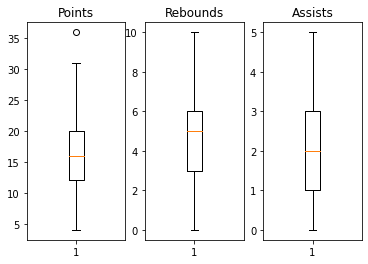

In [11]:
plt.subplot(1,3,1)
plt.boxplot(df.pts)
plt.title('Points')

plt.subplot(1,3,2)
plt.boxplot(df.trb)
plt.title('Rebounds')

plt.subplot(1,3,3)
plt.boxplot(df.ast)
plt.title('Assists')

plt.show()

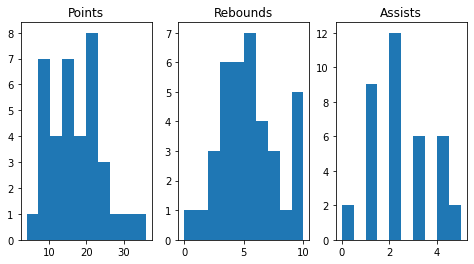

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(8,4))
axs[0].hist(df.pts)
axs[0].set_title('Points')
axs[1].hist(df.trb)
axs[1].set_title('Rebounds')
axs[2].hist(df.ast)
axs[2].set_title('Assists')
plt.show()

In [13]:
train = pd.DataFrame()
for player in players_df:
    df = vars()[player]
    train = pd.concat([train, df])

In [14]:
train.head()

,date,team,team_href,team_opp,team_opp_href,mp,fg,fg_pct,fg3,fg3_pct,...,visit_LgRank_FTr,visit_LgRank_eFG%,visit_LgRank_TOV%,visit_LgRank_ORB%,visit_LgRank_FT/FGA,visit_LgRank_opp_eFG%,visit_LgRank_opp_TOV%,visit_LgRank_DRB%,visit_LgRank_opp_FT/FGA,target
0,2022-10-18,GSW,/teams/GSW/2023.html,LAL,/teams/LAL/2023.html,29.0,8,0.571,4,0.571,...,2.0,18.0,11.0,20.0,2.0,7.0,29.0,13.0,1.0,34.0
1,2022-10-21,GSW,/teams/GSW/2023.html,DEN,/teams/DEN/2023.html,37.0,8,0.471,2,0.250,...,20.0,1.0,24.0,11.0,25.0,15.0,17.0,12.0,9.0,30.0
2,2022-10-23,GSW,/teams/GSW/2023.html,SAC,/teams/SAC/2023.html,31.0,10,0.526,2,0.333,...,9.0,2.0,9.0,22.0,7.0,27.0,13.0,7.0,10.0,25.0
3,2022-10-25,GSW,/teams/GSW/2023.html,PHO,/teams/PHO/2023.html,31.0,7,0.412,2,0.286,...,28.0,22.0,7.0,5.0,26.0,5.0,12.0,17.0,30.0,30.0
4,2022-10-27,GSW,/teams/GSW/2023.html,MIA,/teams/MIA/2023.html,36.0,5,0.500,2,0.400,...,13.0,25.0,14.0,21.0,8.0,25.0,2.0,5.0,7.0,20.0


In [15]:
train.describe()

,mp,fg,fg_pct,fg3,fg3_pct,ft,ft_pct,orb,drb,trb,...,visit_LgRank_FTr,visit_LgRank_eFG%,visit_LgRank_TOV%,visit_LgRank_ORB%,visit_LgRank_FT/FGA,visit_LgRank_opp_eFG%,visit_LgRank_opp_TOV%,visit_LgRank_DRB%,visit_LgRank_opp_FT/FGA,target
count,1942.000000,1942.000000,1937.000000,1942.000000,1740.000000,1942.000000,1431.000000,1942.000000,1942.000000,1942.000000,...,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1912.000000
mean,29.855304,6.207003,0.489756,1.956231,0.352545,2.747683,0.797006,1.132853,4.443872,5.576725,...,15.199794,15.568486,15.807415,15.416581,15.273944,15.812049,15.369207,15.727085,15.845005,26.540272
std,6.976089,3.677128,0.177180,1.894334,0.246327,2.924110,0.254634,1.480723,2.885893,3.595325,...,8.587894,8.542659,8.741522,8.798505,8.597541,8.553086,8.654996,8.601767,8.646839,12.501322
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,25.000000,3.000000,0.389000,0.000000,0.200000,0.000000,0.667000,0.000000,2.000000,3.000000,...,8.000000,8.000000,8.000000,7.000000,8.000000,9.000000,7.250000,8.000000,8.000000,17.000000
50%,31.000000,6.000000,0.500000,2.000000,0.333000,2.000000,0.875000,1.000000,4.000000,5.000000,...,15.000000,15.000000,16.000000,15.000000,15.000000,16.000000,16.000000,16.000000,16.000000,25.000000
75%,35.000000,9.000000,0.600000,3.000000,0.500000,4.000000,1.000000,2.000000,6.000000,8.000000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,35.000000
max,48.000000,22.000000,1.000000,12.000000,1.000000,18.000000,1.000000,12.000000,18.000000,22.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,73.000000


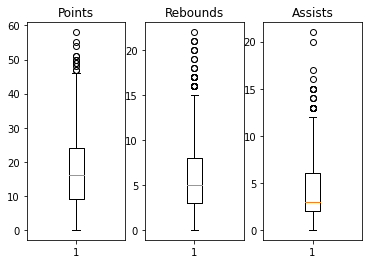

In [16]:
plt.subplot(1,3,1)
plt.boxplot(train.pts)
plt.title('Points')

plt.subplot(1,3,2)
plt.boxplot(train.trb)
plt.title('Rebounds')

plt.subplot(1,3,3)
plt.boxplot(train.ast)
plt.title('Assists')

plt.show()

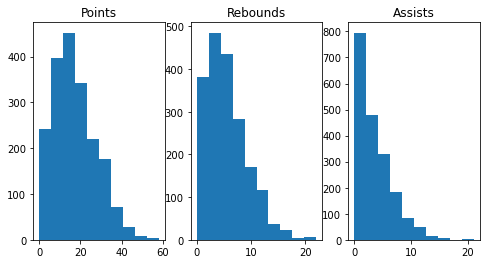

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(8,4))
axs[0].hist(train.pts)
axs[0].set_title('Points')
axs[1].hist(train.trb)
axs[1].set_title('Rebounds')
axs[2].hist(train.ast)
axs[2].set_title('Assists')
plt.show()